## Step 1: Values Import

In [3]:
from utils.file_handling import *
from utils.misc import *
from utils.matplot_handlers import *
from utils.visualizers import *
from segmentation.composite_action_extractor import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

# Entropy Parameters
csv_file_name = 'cartpole'
episodes = -1

pre_data = pd.read_csv(get_absolute_path('data', directory_file_hint=csv_file_name, ignore_files=False) + '/state_action_data.csv', index_col=None)
selected_episodes = pre_data['episode'].unique()[episodes]  # Either do [some index] or [:]
selected_episodes = [selected_episodes] if np.isscalar(selected_episodes) else selected_episodes
data_df = pre_data[pre_data['episode'].isin(selected_episodes)]
data_df_episodes = []
for episode in selected_episodes:
    data_df_episodes.append(data_df[data_df['episode'] == episode].copy())
    
main_df = data_df_episodes[episodes]

In [4]:
main_df

,index,step,action_values_0,state_values,episode
841,0,0,1.0,"[-0.014983282173436502, 0.22033841899336182, -...",450
842,1,1,1.0,"[-0.010576513793569265, 0.4157621603698676, -0...",450
843,2,2,0.0,"[-0.002261270586171914, 0.22104800928203228, -...",450
844,3,3,1.0,"[0.002159689599468732, 0.4167304069562996, -0....",450
845,4,4,0.0,"[0.010494297738594723, 0.2223116972276884, -0....",450
846,5,5,0.0,"[0.014940531683148493, 0.028112836144241538, -...",450
847,6,6,1.0,"[0.015502788406033323, 0.22415251344632953, -0...",450
848,7,7,0.0,"[0.019985838674959913, 0.03010764028051585, -0...",450
849,8,8,0.0,"[0.02058799148057023, -0.16378897811894805, -0...",450
850,9,9,1.0,"[0.017312211918191267, 0.03241458758461355, -0...",450


The entropy segmentation function is able to accept a dataframe, or 2 matricies representing the action values and state values. The format for both matricies will be as follows depending on the input type. 

**Dataframe / Tabular Input Format**

Action columns should have a key of `action_value` and the state columns should have a key of `state_value`. As a note, it is expected that the `state_value` column contain lists for the state values. Pandas stores python lists as strings. Perhaps in the future the function can also detect pickled values, however for now, the fuction will take the state column and cast the list lists to python lists.

**Raw Matrix Input Format**

_Action Matrix_
                  
$
A_{t,n} = 
 \begin{pmatrix}
  a_{0,1} & a_{0,2} & \cdots & a_{0,n} \\
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{t,1} & a_{t,2} & \cdots & a_{t,n} 
 \end{pmatrix}
$


Where $t$ is the time step, and $n$ is the action type. Many simpler environments may only have $n=1$ however larger multi-joint robots will have more.


_State Matrix_

$
S_{t,n} = 
 \begin{pmatrix}
  s_{0,1} & s_{0,2} & \cdots & s_{0,n} \\
  s_{1,1} & s_{1,2} & \cdots & s_{1,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  s_{t,1} & s_{t,2} & \cdots & s_{t,n} 
 \end{pmatrix}
$

Similar to actions, $t$ is the time step, but unlike actions $n$ is the dimension of the state. It is expected that that for every time step, the state is a flattened vector where each time step, one can access the entire state.  


In [5]:
A_t_n = main_df[[_ for _ in main_df.columns if _.__contains__('action_value')]].values
string_S_t_n = main_df[[_ for _ in main_df.columns if _.__contains__('state_values')]].values

In [6]:
S_t_n = np.array([list_of_str_to_num(_)[0] for _ in string_S_t_n])
A_t_n = A_t_n if A_t_n.shape[1] != 0 else A_t_n.reshape(-1, 1)

In [7]:
S_t_n.shape, A_t_n.shape

((169, 4), (169, 1))

## Step 2: Binning / Windowing
Our algorithm given some function (entropy / distance) $f$, extracts the average state measure. We also use $w$ as the window size to slide along the sequence. We descritize the values for handling real numbers via binning defined by n bins $b$.

$S_d = f(S, w, b)$

$A_d = f(A, w, b)$


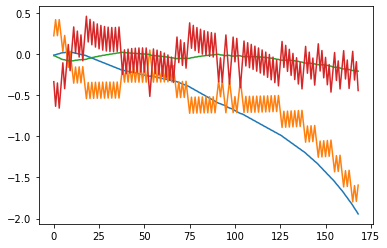

In [8]:
plt.plot(S_t_n)

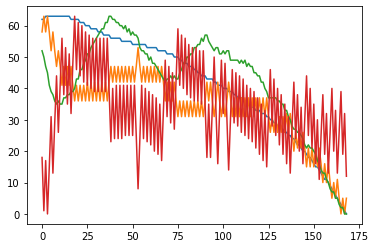

In [9]:
w = 5
b = 64
S_b = np.apply_along_axis(partial(bin_numpy, bins=b), 0, S_t_n)
plt.plot(S_b)

Now that the values are binned, we can extract probabilities from a series that would have otherwise required continuous integration.

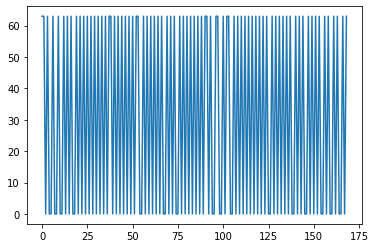

In [10]:
A_b = np.apply_along_axis(partial(bin_numpy, bins=b), 0, A_t_n)
plt.plot(A_b)

Now that we have the matrices converted to bins, we then create windowed series for the methods to operate on.

In [11]:
windowed_actions = compositeActionExtractor.get_windowed_series(A_b, w)[:10]
print(compositeActionExtractor.get_windowed_series(A_b, w)[:10])
print(f'\n {windowed_actions.shape} where axis 0 is the number time steps, 1')
print(' is the dimension, and 2 is the window.')

NameError: name 'compositeActionExtractor' is not defined

## Step 3: Analysis
Next get the measurements based on the function type we chose. For now, we use kl divergence. We have better functions for quickly getting the binned, windowed, and probabilistic versions of the matrices.

In [ ]:
# Generates binned and windowed versions of the matrices.
S_bw = compositeActionExtractor.bin_p_window(S_t_n, w, b, p_per_dim=False)
A_bw = compositeActionExtractor.bin_p_window(A_t_n, w, b, p_per_dim=True)
print(f' {S_bw.shape} (timesteps, dimension, window)')
print(f' {A_bw.shape} (timesteps, action, window)')

Next we use a entropy, distance, or measure for extracting action segments. Available methods are:
- shannon entropy 
- approximate 
- sample
- permutation
- jensen_shannon
- total_variance
- kl_divergence
- wasserstein

We also introduce another parameter $\lambda$ which will be a range from 0 - 1, indicating the threshhold. 

In [ ]:
thresh = 0.5

state_analyzed = compositeActionExtractor.analyze(S_bw, method='kld', collapse_by_average=True)
action_analyzed = compositeActionExtractor.analyze(A_bw, method='kld', collapse_by_average=False)
plt.plot(state_analyzed, label='State Entropy / Distance / Measure')
plt.plot(action_analyzed, label='Action Entropy / Distance / Measure')
cutoff = np.full(state_analyzed.shape, thresh)
plt.plot(cutoff, label='We keep segments above the threshhold')
plt.legend()

In [ ]:
# We normalize the outputs. state_analyzed is normalized globally, while action_analyzed is normalized action wise.
state_analyzed_norm = compositeActionExtractor.normalize(state_analyzed)
action_analyzed_norm = compositeActionExtractor.normalize(action_analyzed, norm_per_dim=True)
plt.plot(state_analyzed_norm, label='State Entropy / Distance / Measure')
plt.plot(action_analyzed_norm, label='Action Entropy / Distance / Measure')
plt.plot(cutoff, label='We keep segments above the threshhold')
plt.legend()

In [ ]:
# We get versions of the state and action variables but as binary distributions based on the cutoff
state_analyzed_binary = compositeActionExtractor.get_binary_dist(state_analyzed_norm, thresh)
action_analyzed_binary = compositeActionExtractor.get_binary_dist(action_analyzed_norm, thresh, per_dim=True)
plt.plot(state_analyzed_binary, label='State Entropy / Distance / Measure')
plt.plot(action_analyzed_binary, label='Action Entropy / Distance / Measure')
plt.legend()

In [ ]:
# Now using the state and action spaces, we can estimate the most likely segments of actions. 
# We keep actions that are near state events
l_w = 10#w // 2 + 1
r_w = 10# w // 2
valid_segments = [(True in action_analyzed_binary[:, 0][i - l_w:i + r_w] and True in state_analyzed_binary[i - l_w:i + r_w]) for i in range(state_analyzed_binary.shape[0])]
plt.plot(valid_segments, label='Action 0 Segments')
plt.title('These are the grouped composite actions. \nThese are the grouped atomic actions that are correlated with the state changes.')

In [ ]:
groups = compositeActionExtractor.get_bin_group(valid_segments)
plt.plot(groups, label='Action 0 Segments')

In [ ]:
composite_actions = compositeActionExtractor.get_single_composite_actions(A_t_n, groups)
plt.plot(A_t_n)
for i, composite_action in enumerate(composite_actions):
    plt.plot(composite_action, label=f'composite Action #{i}')
plt.legend()